# This is the New York City Taxi Fare Prediction Playground Competition 

In [158]:

import numpy as np # linear algebra
from matplotlib import pyplot as plt # nice& easy plots
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

train_df =  pd.read_csv("/Users/lucamainitz/Library/Mobile Documents/com~apple~CloudDocs/HAWK/3. Semester/Machine_Learning_WPF/MLA_Kaggle_NY_Taxi_Data/train.csv", nrows = 10_000_000)
# if there are any `NaN`s in the db remove these
train_df = train_df.dropna(how = 'any', axis = 'rows')

train_df = train_df[(train_df.fare_amount > 0)]
train_df = train_df[(train_df.fare_amount <= 250)]

### Analysis of the pickup and dropoff coordinates including deletion of unrealistic values :

In [159]:
# some stats about our coordinates
# Expectations based on the coordinates of NYC and its surrounding: 
longMin = -76
longMax = -72
latMin = 38
latMax = 42

# find unrealistic coordinates & remove datapoints
train_df = train_df[(train_df.pickup_longitude >= longMin) & (train_df.pickup_longitude <= longMax)
                   & (train_df.dropoff_longitude >= longMin) & (train_df.dropoff_longitude <= longMax) 
                   & (train_df.pickup_latitude >= latMin) & (train_df.pickup_latitude <= latMax) 
                   & (train_df.dropoff_latitude >= latMin) & (train_df.dropoff_latitude <= latMax)]


In [160]:

# delete data points with 0 passengers and more than 10 passengers
train_df = train_df[(train_df.passenger_count != 0) & (train_df.passenger_count < 10)]

# add two new features 'abs_diff_longitude' and 'abs_diff_latitude' reprensenting the "Manhattan vector" from the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [161]:
import math

#straight line distances:

lat2km = 111.5
long2km = 84

# add travel length feature:
def add_straight_distance_feature(df):
    df['straight_distance'] = (((train_df.abs_diff_longitude * long2km)**2+(train_df.abs_diff_latitude * lat2km)**2)**0.5)
    df['straight_distance'] = df['straight_distance'].fillna(0)
    
add_straight_distance_feature(train_df)

train_df = train_df[(train_df.straight_distance != 0)]


### Adding Manhatten Distance

In [162]:

# add manhatten distance feature:

def add_manhattan_distance(df):
    df['manhattan_distance'] = df.abs_diff_longitude + df.abs_diff_latitude
    df['manhattan_distance'] = df['manhattan_distance'].fillna(0)

add_manhattan_distance(train_df)


### Adding Airport distances 

In [163]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

add_airport_dist(train_df)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,straight_distance,manhattan_distance,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.033288,0.011742,20.265840,55.176046,14.342611,34.543548,27.572573
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.466957,0.107481,44.667679,31.832358,23.130775,15.125872,8.755732
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391321,0.019212,43.597686,33.712082,19.865289,17.722624,9.847344
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.806670,0.029386,42.642965,32.556289,21.063132,15.738963,7.703421
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.002245,0.027194,43.329953,39.406828,15.219339,23.732406,15.600745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,2012-08-12 01:18:00.000000208,5.7,2012-08-12 01:18:00 UTC,-73.999464,40.728452,-73.993299,40.742100,2,0.006165,0.013648,1.607454,0.019813,42.417121,30.577734,22.874572,13.079800,4.988344
9999996,2013-08-07 10:28:00.000000147,5.5,2013-08-07 10:28:00 UTC,-73.968467,40.759367,-73.964967,40.769027,1,0.003500,0.009660,1.116494,0.013160,42.072620,37.585360,16.144429,21.218134,12.983468
9999997,2013-10-29 08:29:00.00000082,14.0,2013-10-29 08:29:00 UTC,-73.997952,40.733717,-73.973448,40.759122,5,0.024504,0.025405,3.501528,0.049909,42.324600,33.133799,20.342237,16.129625,8.004804
9999998,2012-04-07 16:41:33.0000004,10.5,2012-04-07 16:41:33 UTC,-73.992700,40.752021,-73.964705,40.772849,1,0.027995,0.020828,3.305013,0.048823,43.479486,35.599943,18.265876,19.714291,11.774492


In [164]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    return dataset

train_df = add_datetime_info(train_df)


### Add Late night surcharge

In [165]:

def add_rush_hour (df):
    if ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 18)):
        val = 1
    else:
        val = 0
    return val

def add_late_night (df):
    if (df['hour'] <= 6) | (df['hour'] >= 20):
        val = 1
    else:
        val = 0
    return val


def add_night (df):
    if ((df['hour'] <= 20) & (df['hour'] >= 16)) & (df['weekday'] < 5):
        val = 1
    else:
        val = 0
    return val

train_df['rush_hour'] = train_df.apply(add_rush_hour, axis=1)
train_df['late_night'] = train_df.apply(add_late_night, axis=1)
train_df['night'] = train_df.apply(add_night, axis=1)

In [166]:
from sklearn import model_selection, preprocessing

# splitte die labels von den features
def defineLabels(df):
    labels_df = df[['fare_amount']].copy()
    return labels_df

train_labels = defineLabels(train_df)

def defineFeatures(df):  
    features_df = df[['manhattan_distance', 'hour', 'day', 'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'night', 'late_night', 'rush_hour']].copy()
    # features_df = df[['manhattan_distance', 'hour', 'day', 'weekday', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'night', 'late_night', 'rush_hour']].copy()
    return features_df

# def scale_features(features_df):
#     scaler = preprocessing.MinMaxScaler()
#     features_scaled = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)
#     return features_scaled


train_features = defineFeatures(train_df)

scaler = preprocessing.MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)

train_x, val_x, train_y, val_y = model_selection.train_test_split(features_scaled, train_labels, test_size=0.2, random_state=42)


train_x = train_x[:80000]
train_y = train_y[:80000]
val_x = val_x[:20000]
val_y = val_y[:20000]

# Step 3: Select a Model

In [178]:
import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras

dropout_rate = 0.2

model = keras.Sequential()
model.add(keras.layers.Dense(256,  activation='relu', input_dim=train_x.shape[1], activity_regularizer=regularizers.l1(0.001)))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(rate = dropout_rate))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(rate = dropout_rate))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(rate = dropout_rate))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(rate = dropout_rate))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(rate = dropout_rate))
model.add(keras.layers.Dense(1))

model.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

2.15.0
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 256)               3584      
                                                                 
 batch_normalization_88 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_87 (Dropout)        (None, 256)               0         
                                                                 
 dense_106 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_89 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_88 (Dropout)        (None, 128)      

In [179]:
from keras.callbacks import EarlyStopping
# train the model
epochs = 500
batch_size = 64

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10)

# train the model with early stopping
history = model.fit(
    train_x,
    train_y,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping])



Epoch 1/500
1250/1250 [==============================] - 2s 1ms/step - loss: 222.7166 - root_mean_squared_error: 14.9232 - val_loss: 212.6374 - val_root_mean_squared_error: 14.5816
Epoch 2/500
1250/1250 [==============================] - 1s 1ms/step - loss: 220.5448 - root_mean_squared_error: 14.8503 - val_loss: 210.3501 - val_root_mean_squared_error: 14.5030
Epoch 3/500
1250/1250 [==============================] - 1s 1ms/step - loss: 218.4689 - root_mean_squared_error: 14.7802 - val_loss: 208.6912 - val_root_mean_squared_error: 14.4456
Epoch 4/500
1250/1250 [==============================] - 1s 1ms/step - loss: 216.6127 - root_mean_squared_error: 14.7173 - val_loss: 206.7014 - val_root_mean_squared_error: 14.3766
Epoch 5/500
1250/1250 [==============================] - 1s 1ms/step - loss: 215.1184 - root_mean_squared_error: 14.6664 - val_loss: 204.2436 - val_root_mean_squared_error: 14.2909
Epoch 6/500
1250/1250 [==============================] - 1s 1ms/step - loss: 213.3250 - root_me

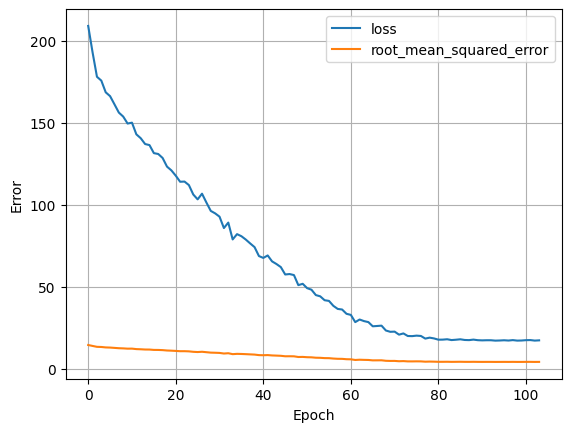

In [ ]:
def plot_loss(history):
  plt.plot(history.history['val_loss'], label='loss')
  plt.plot(history.history['val_root_mean_squared_error'], label='root_mean_squared_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

# load keras model
model = keras.models.load_model('my_model.keras')

In [ ]:
# evaluate model performance
score = model.evaluate(val_x, val_y, verbose=0)
print("Test loss: {:.4f}".format(score[0]))
print("Test accuracy: {:.4f}".format(score[1]))


Test loss: 17.3024
Test accuracy: 4.1572


In [ ]:
# test data alsready loaded as test_df
test_df = pd.read_csv("/Users/lucamainitz/Library/Mobile Documents/com~apple~CloudDocs/HAWK/3. Semester/Machine_Learning_WPF/MLA_Kaggle_NY_Taxi_Data/test.csv")

# create used features
add_travel_vector_features(test_df)
add_straight_distance_feature(test_df)
add_manhattan_distance(test_df)
add_airport_dist(test_df)
add_datetime_info(test_df)

test_df['rush_hour'] = test_df.apply(add_rush_hour, axis=1)
test_df['late_night'] = test_df.apply(add_late_night, axis=1)
test_df['night'] = test_df.apply(add_night, axis=1)

# check for null values in extented test data to avoid wrong predictions
print(test_df.isnull().sum())
distZeroCount = 0

print(test_df.describe())


key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
straight_distance     0
manhattan_distance    0
jfk_dist              0
ewr_dist              0
lga_dist              0
sol_dist              0
nyc_dist              0
hour                  0
day                   0
month                 0
weekday               0
year                  0
rush_hour             0
late_night            0
night                 0
dtype: int64
                     pickup_datetime  pickup_longitude  pickup_latitude  \
count                           9914       9914.000000      9914.000000   
mean   2012-05-06 09:24:04.549122560        -73.974722        40.751041   
min              2009-01-01 11:04:24        -74.252193        40.573143   
25%              2010-11-17 19:10:23        -73.992501        40.736125   
50%              2012-01-26 07:33:00

In [ ]:
test_features = defineFeatures(test_df)

test_features_scaled_df = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

# predict on data
prediction = model.predict(test_features_scaled_df, verbose=1)

# print(prediction)
# prediction_df = pd.DataFrame(prediction)
# print(prediction_df.describe())

310/310 [==============================] - 0s 482us/step


In [ ]:
#backscaling by factor ~ 250
#scaler = preprocessing.MinMaxScaler()
#features_scaled = scaler.fit_transform(features_df)
#prediction_inverse = scaler.inverse_transform(prediction)
#print(prediction_inverse)
print('min',np.min(prediction),'max',np.max(prediction),'mean',np.mean(prediction))
#rescaled_prediction = prediction * 250
#print(rescaled_prediction)
#print('min',np.min(rescaled_prediction),'max',np.max(rescaled_prediction),'mean',np.mean(rescaled_prediction))

min -5.6861897 max 89.278015 mean 11.414447


### Make Kaggle Submission

In [ ]:
#submission = pd.DataFrame(rescaled_prediction, columns=['fare_amount'])
submission = pd.DataFrame(prediction, columns=['fare_amount'])
submission.insert(0, "key", test_df.key, True)

print(submission.head())
submission_df = pd.DataFrame(submission)
print(submission_df.describe())
submission_df['fare_amount']

fareZeroCount = 0
for fare in submission_df['fare_amount']:
    if (fare <= 0):
        fareZeroCount += 1
#print(test_df)
print('Number of zero or negative values in submission: ', fareZeroCount)



# submission_null = submission[submission['fare_amount'].isnull()]

# # Add values from test_df with matching key column to submission_null
# submission_null = submission_null.merge(test_df, on='key', how='left')
# submission_null.to_csv('submission_null.csv', index = False)
# print(submission_null.head())

submission.to_csv('submission.csv', index = False)

# pd.DataFrame(data=data[1:,1:],    # values
#              index=test_df[1:,0],    # 1st column as index
#              columns=data[0,1:])  # 1st row as the column names


                           key  fare_amount
0  2015-01-27 13:08:24.0000002     9.757931
1  2015-01-27 13:08:24.0000003    10.526383
2  2011-10-08 11:53:44.0000002     5.338548
3  2012-12-01 21:12:12.0000002     6.914999
4  2012-12-01 21:12:12.0000003    12.844368
       fare_amount
count  9914.000000
mean     11.414447
std       8.549770
min      -5.686190
25%       6.775256
50%       8.540938
75%      12.315055
max      89.278015
Number of zero or negative values in submission:  3


In [ ]:
submission.to_csv();